<a href="https://colab.research.google.com/github/cibic89/btc_forecast/blob/main/btc_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

T4 works great for this problem

In [ ]:
# !rm -rf 30-day

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U autogluon
!pip install dask[dataframe]

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from math import ceil
import os

In [ ]:
# def find_latest_folder(path):
#     latest_folder = None

#     try:
#         # Get a list of all folders in the directory
#         folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

#         # Sort the folders alphanumerically in ascending order
#         folders.sort()

#         # Get the last folder in the sorted list
#         latest_folder = folders[-1]
#     except FileNotFoundError:
#         pass

#     return latest_folder

In [ ]:
dtp = 7  # prediction length
path_to_directory = str(dtp)+"-day"
date_today = pd.to_datetime("today").strftime("%Y-%m-%d")
latest_folder = None  # find_latest_folder(path_to_directory)

result_dir = 'drive/MyDrive/code_projects/btc_forecast/results/'+path_to_directory+'/'
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print("Error: Failed to create the directory.")
# base_dir = 'drive/MyDrive/code_projects/btc_forecast/'

In [ ]:
df = pd.read_csv('drive/MyDrive/code_projects/btc_forecast/Bitstamp_BTCUSD_d.csv', skiprows=1, parse_dates=["date"])
df = df.sort_values('date').drop(columns=["unix"]).reset_index(drop=True).iloc[:-1]
df.tail(2)

,date,symbol,open,high,low,close,Volume BTC,Volume USD
3702,2025-01-16,BTC/USD,100512.0,100860.0,97319.0,99975.0,1817.774606,1.817320e+08
3703,2025-01-17,BTC/USD,99975.0,105932.0,99944.0,104119.0,3087.397081,3.214567e+08


In [ ]:
df.dtypes, df.shape

(date          datetime64[ns]
 symbol                object
 open                 float64
 high                 float64
 low                  float64
 close                float64
 Volume BTC           float64
 Volume USD           float64
 dtype: object,
 (3704, 8))

In [ ]:
ml_df = TimeSeriesDataFrame.from_data_frame(
    df,  # [df["date"]> '2022-11-08'],  # selecting data from last bull run - not a good idea (makes the model too optimistic)
    id_column="symbol",
    timestamp_column="date"
)
train_data = ml_df
# train_data, test_data = ml_df.train_test_split(prediction_length=dtp)
# print(train_data.shape, test_data.shape)

In [ ]:
train_data.tail(2)

open      high      low     close   Volume BTC  \
item_id timestamp                                                        
BTC/USD 2025-01-16  100512.0  100860.0  97319.0   99975.0  1817.774606   
        2025-01-17   99975.0  105932.0  99944.0  104119.0  3087.397081   

                      Volume USD  
item_id timestamp                 
BTC/USD 2025-01-16  1.817320e+08  
        2025-01-17  3.214567e+08

In [ ]:
# test_data.tail(2)

Rolling-window count: 123
Validation data size: 0.996
Val step size: 30


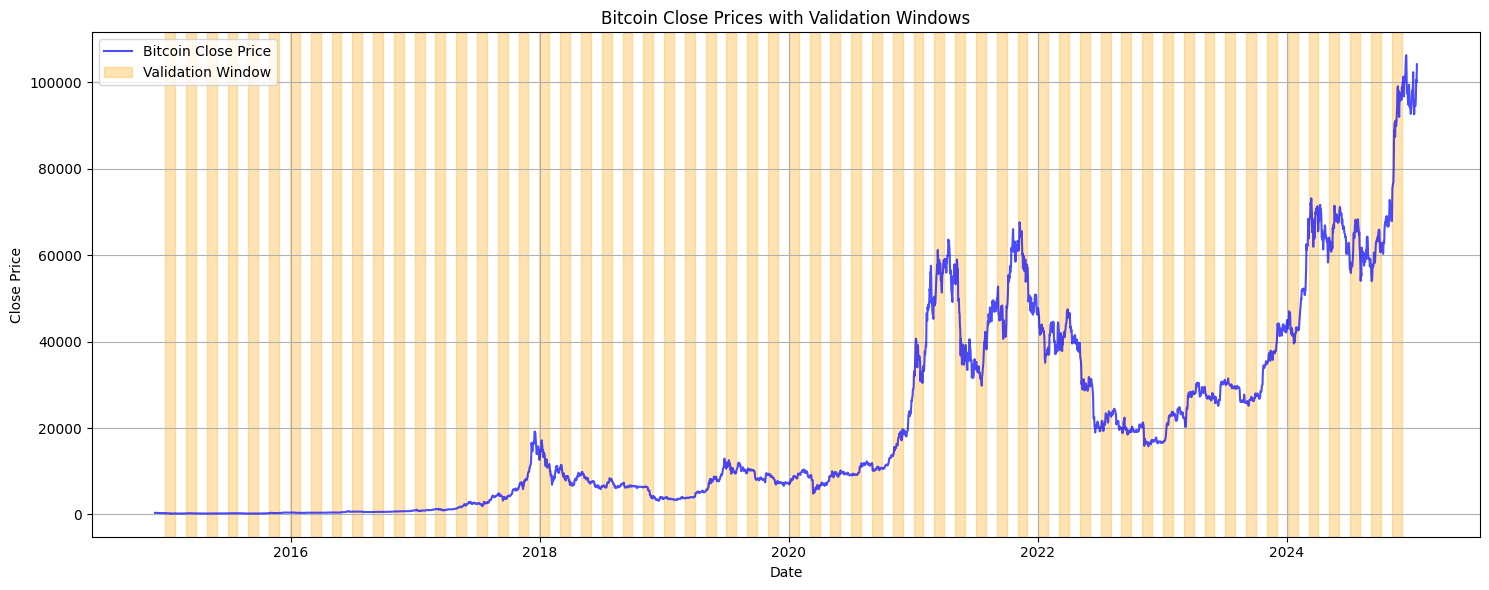

In [ ]:
train_data_size = (len(train_data))  # -dtp

n_windows = (train_data_size//dtp)
print("Rolling-window count:", n_windows)

val_size = n_windows*dtp
val_size_pc = round(val_size/train_data_size, 3)
print("Validation data size:", val_size_pc)

val_step_size_n = dtp  # (train_data_size//n_windows)//2  # 15
print("Val step size:", val_step_size_n)

viz_df = train_data.reset_index().set_index("timestamp")

# Define validation window parameters
window_size = len(viz_df) // n_windows

# Ensure the windows span the entire dataset, including at the end
validation_windows = []
current_iloc = 0
for i in range(n_windows):
    start_idx = current_iloc + window_size
    end_idx = start_idx + dtp
    if end_idx <= len(viz_df):  # Ensure indices are within bounds
        validation_windows.append((start_idx, end_idx))
    current_iloc = end_idx + 1

# Plot the Bitcoin close prices
plt.figure(figsize=(15, 6))
plt.plot(viz_df.index, viz_df["close"], label="Bitcoin Close Price", color="blue", alpha=0.7)

# Highlight validation windows
for start_idx, end_idx in validation_windows:
    plt.axvspan(viz_df.index[start_idx], viz_df.index[end_idx - 1],
                color="orange", alpha=0.3,
                label="Validation Window" if start_idx == validation_windows[0][0] else None)

# Add labels and legend
plt.title("Bitcoin Close Prices with Validation Windows")  # with n-fold: "+str(z))
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.tight_layout()

try:
    plt.savefig(result_dir+date_today+'_val_windows.png')
except Exception as e:
    print(e)
    pass

plt.show()

In [ ]:
# models = ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'NPTS', 'DynamicOptimizedTheta',
#           'AutoETS', 'ChronosZeroShot[bolt_base]', 'ChronosFineTuned[bolt_small]',
#           'TemporalFusionTransformer', 'DeepAR', 'PatchTST', 'TiDE']
# included_models = ["ChronosFineTuned[bolt_small]", "ChronosZeroShot[bolt_base]"]
# # included_models = ["SeasonalNaive"]
# excluded_model_types = [model for model in models if model not in included_models]
# excluded_model_types = ['NPTS']

In [16]:
# Get today's date
today = pd.to_datetime("today")
max_date = df["date"].max()+pd.Timedelta(days=dtp)
max_train_dur = 86400

# Check if the given date is older or equal to today's date
if (max_date >= today) and (latest_folder is not None):
    print("Using existing model")
    predictor = TimeSeriesPredictor.load(path_to_directory+os.sep+latest_folder)
else:
    print("Training a new model, this will take up to "+str(max_train_dur//60//60)+" hours")
    predictor = TimeSeriesPredictor(
        prediction_length=dtp,
        target="close",
        eval_metric="RMSE",
        path=path_to_directory  # base_dir
    )

    predictor.fit(
        train_data,
        presets="best_quality",  # 'fast_training'
        time_limit=max_train_dur,
        num_val_windows=n_windows,        # Rolling validation windows
        val_step_size=val_step_size_n,  # Controlling overlapping between validation windows, len(train_data)//n_windows means this:
        #|-------------------|
        #| x x x x x y y - - |
        #          | x x x x x x y y - |
        #                      | x x x x x x x y y |
        # val_step_size=1 (default) means this (and set num_val_windows to something very high e.g. 1/3 of dataset):
        #|-------------------|
        #| x x x x x y y - - |
        #| x x x x x x y y - |
        #| x x x x x x x y y |
        refit_full=True,
        # excluded_model_types = excluded_model_types
    )

Beginning AutoGluon training... Time limit = 86400s
AutoGluon will save models to '/content/30-day'


Training a new model, this will take up to 24 hours


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.97 GB / 12.67 GB (86.5%)
Disk Space Avail:   201.97 GB / 235.68 GB (85.7%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 123,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': True,
 'skip_model_selection': False,
 'target': 'close',
 'time_limit': 86400,
 'val_step_size': 30,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 3704 rows, 1 time series. Median time series length is 3704 (min=3704, max=3704). 
Time series in 

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-2533.4584    = Validation score (-RMSE)
	295.60  s     = Training runtime
	1.98    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. Training for up to 16865.8s of the 84929.0s of remaining time.
	Skipping covariate_regressor since the dataset contains no covariates or static features.


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W2/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W3/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W4/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W5/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W6/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W7/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W8/fine-tuned-ckpt
	Saving fine-tuned model to /content/30-day/models/ChronosFineTuned[bolt_small]/W9/fine-tuned-ckpt
	Saving fi

In [17]:
# The test score is computed using the last dts of each time series in test_data
leaderboard_df = predictor.leaderboard(train_data).sort_values(["score_val"], ascending=False)  # test_data
try:
    leaderboard_df.to_csv(result_dir+date_today+'_leaderboard.csv')
except Exception as e:
    print(e)
    pass

display(leaderboard_df)
# leaderboard_df.loc[leaderboard_df[["score_test", "score_val"]].mean(axis=1).sort_values().index[-1]]

all_hyperparams = {}

# Iterate over all rows in the leaderboard
for model_name in leaderboard_df["model"]:
    # Load the model object from predictor._trainer
    model_obj = predictor._trainer.load_model(model_name)

    # Extract hyperparameters (for many models, this is stored in .params)
    hyperparams = model_obj.params

    # Store them in a dictionary keyed by model name
    all_hyperparams[model_name] = hyperparams

# Now all_hyperparams is a dict of model_name -> hyperparam dict
print(all_hyperparams)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
2,WeightedEnsemble,-3272.632229,-1708.719251,0.346705,0.218042,180.840706,13
1,PatchTST,-3018.577729,-1800.466868,0.037121,0.016743,4567.732583,11
15,TiDE,-5390.763070,-1881.022914,0.055244,0.019829,15714.763354,12
7,DeepAR,-3865.702510,-2068.631616,0.160893,0.149895,10694.912975,10
9,TemporalFusionTransformer,-4000.571778,-2141.443150,0.090760,0.031574,7909.322134,9
11,DynamicOptimizedTheta,-4405.166305,-2366.076928,0.371015,0.315078,126.509735,5
13,AutoETS,-5136.454856,-2446.873258,1.300545,1.155849,114.544407,6
5,ChronosZeroShot[bolt_base],-3371.514443,-2533.458370,2.309336,1.977310,295.602897,7
18,SeasonalNaive,-7289.634620,-2593.472550,0.011890,0.016724,4.412535,1
16,RecursiveTabular,-6499.183680,-2789.734076,0.424028,0.323959,335.285348,2


{'WeightedEnsemble': {}, 'PatchTST': {}, 'TiDE': {'encoder_hidden_dim': 256, 'decoder_hidden_dim': 256, 'temporal_hidden_dim': 64, 'num_batches_per_epoch': 100, 'lr': 0.0001}, 'DeepAR': {}, 'TemporalFusionTransformer': {}, 'DynamicOptimizedTheta': {}, 'AutoETS': {}, 'ChronosZeroShot[bolt_base]': {'model_path': 'bolt_base'}, 'SeasonalNaive': {}, 'RecursiveTabular': {}, 'ChronosFineTuned[bolt_small]': {'model_path': 'bolt_small', 'fine_tune': True, 'target_scaler': 'standard', 'covariate_regressor': {'model_name': 'CAT', 'model_hyperparameters': {'iterations': 1000}}}, 'DirectTabular': {}, 'NPTS': {}, 'PatchTST_FULL': {}, 'WeightedEnsemble_FULL': {}, 'ChronosZeroShot[bolt_base]_FULL': {'model_path': 'bolt_base'}, 'DeepAR_FULL': {}, 'TemporalFusionTransformer_FULL': {}, 'DynamicOptimizedTheta_FULL': {}, 'AutoETS_FULL': {}, 'TiDE_FULL': {'encoder_hidden_dim': 256, 'decoder_hidden_dim': 256, 'temporal_hidden_dim': 64, 'num_batches_per_epoch': 100, 'lr': 0.0001}, 'SeasonalNaive_FULL': {}, 'C

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Usi

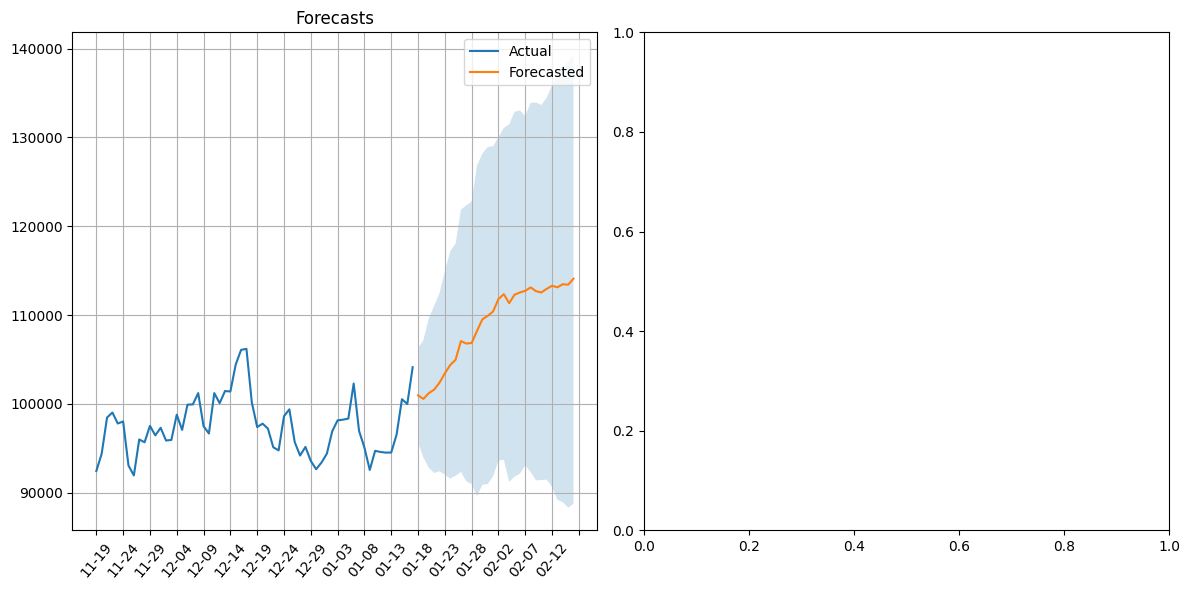

In [18]:
# Split the data points in half
viz_dp = dtp * 2

# Label config
x_lbl_bins = 20
x_lbl_rot = 50

# # predictions = predictor.predict(train_data)  # , model=model_to_use)
# # predictions.tail(2)

forecasts = predictor.predict(train_data)  # , model=model_to_use)
# # forecasts.head()

# # Reset the index to access 'timestamp' as a column
train_data_reset = train_data.reset_index().iloc[-viz_dp:]
# test_data_reset = test_data.reset_index().iloc[-viz_dp:]
# predictions_reset = predictions.reset_index().iloc[-viz_dp:]
forecasts_reset = forecasts.reset_index().iloc[-viz_dp:]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Format the dates to display only month and day
train_data_reset['timestamp'] = train_data_reset['timestamp'].dt.strftime('%m-%d')
# test_data_reset['timestamp'] = test_data_reset['timestamp'].dt.strftime('%m-%d')
# predictions_reset['timestamp'] = predictions_reset['timestamp'].dt.strftime('%m-%d')
forecasts_reset['timestamp'] = forecasts_reset['timestamp'].dt.strftime('%m-%d')

# # Plot the first set of time series and forecasts on the first subplot
axes[0].plot(train_data_reset['timestamp'], train_data_reset['close'], label='Actual')
# axes[0].plot(test_data_reset['timestamp'], test_data_reset['close'], label='Actual')
axes[0].plot(forecasts_reset['timestamp'], forecasts_reset['mean'], label='Forecasted')
axes[0].fill_between(forecasts_reset['timestamp'], forecasts_reset['0.1'], forecasts_reset['0.9'], alpha=0.2)
axes[0].set_title('Forecasts')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=x_lbl_rot)
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=x_lbl_bins))  # Limit the number of x-axis labels
axes[0].grid(True)

# # Plot the second set of time series and forecasts on the second subplot
# axes[1].plot(test_data_reset['timestamp'], test_data_reset['close'], label='Actual')
# axes[1].plot(predictions_reset['timestamp'], predictions_reset['mean'], label='Predicted')
# axes[1].fill_between(predictions_reset['timestamp'], predictions_reset['0.1'], predictions_reset['0.9'], alpha=0.2)
# axes[1].set_title('Predictions')
# axes[1].legend()
# axes[1].tick_params(axis='x', rotation=x_lbl_rot)
# axes[1].xaxis.set_major_locator(MaxNLocator(nbins=x_lbl_bins))  # Limit the number of x-axis labels
# axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

try:
    plt.savefig(result_dir+date_today+'_forecasts.png')
except Exception as e:
    print(e)
    pass

# Show the combined figure
plt.show()